## 8. Redes neuronales LSTM

En esta parte vamos a probar con una red neuronal para poder hacer predicciones de la serie temporal.

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
%matplotlib notebook

In [8]:
tf.random.set_seed(2)

### 8.1 Carga de datos

In [9]:
df = pd.read_csv('./data/coffee.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


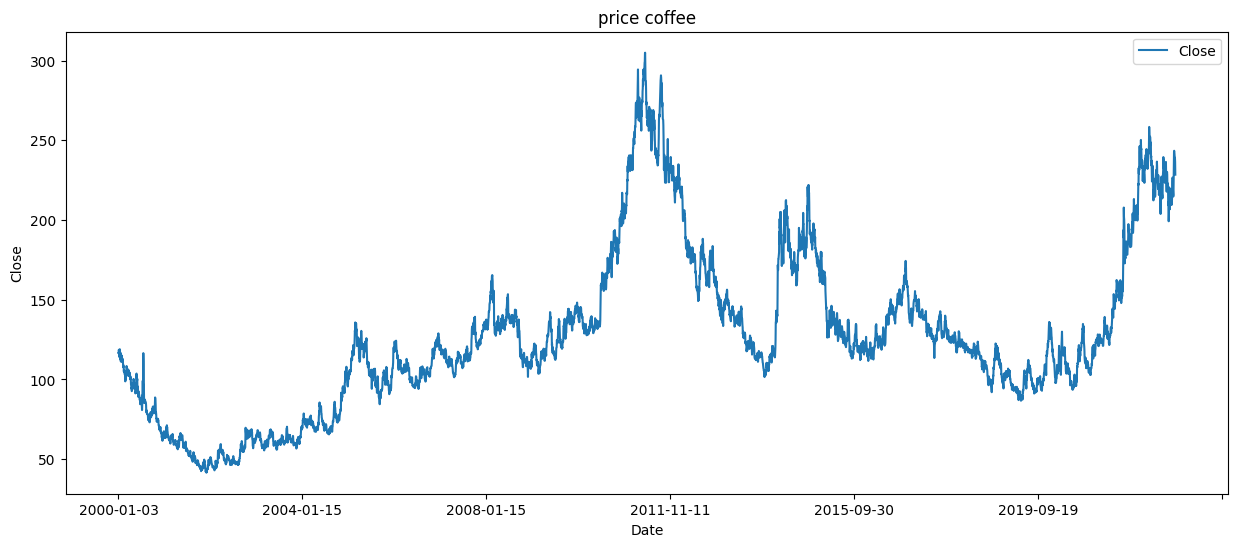

In [10]:
df.plot(x = "Date", y= "Close", figsize=(15, 6))
plt.title(f'price coffee')
plt.xlabel('Date')
plt.ylabel("Close")
plt.show()

### 8.2 Preparación de los datos para la red

nos quedamos con la variable 'Close' y armamos nuesta serie para poder pre-procesarla para la red

In [167]:
df_1 = df.set_index(pd.DatetimeIndex(df['Date']))
df_1.sort_index(ascending=True, inplace=True)
df_1=df_1['Close']

Pasamos el dataset a float32 y normalizamos de 0 a 1.

In [168]:
dataset = df_1.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [169]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Dividimos el dataset para entrenamiento y test

In [170]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4022 1724


Creamos una función que tiene dos argumentos: el dataset y un look back que es el número de pasos hacia atrás que se toman en cuenta para hacer la predicción del paso siguiente.

In [171]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [172]:
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [173]:
X_train.shape

(4018, 3)

In [174]:
Y_train.shape

(4018,)

Podemos ver como acabamos de construir un dataset que a cada 3 paso de X se "predice" 1 paso en Y. 

In [175]:
# reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

In [176]:
X_train.shape

(4018, 1, 3)

In [177]:
Y_train.shape

(4018,)

### 8.3 Creación de la red neuronal

In [178]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back),  return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 128)            67584     
                                                                 
 dropout_37 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)               

In [179]:
hist = model.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
3214/3214 [==============================] - 10s 3ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 3.9392e-04 - val_rmse: 0.0198
Epoch 2/10
3214/3214 [==============================] - 8s 2ms/step - loss: 0.0029 - rmse: 0.0542 - val_loss: 2.9234e-04 - val_rmse: 0.0171
Epoch 3/10
3214/3214 [==============================] - 8s 2ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 3.4490e-04 - val_rmse: 0.0186
Epoch 4/10
3214/3214 [==============================] - 8s 2ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 9.4842e-04 - val_rmse: 0.0308
Epoch 5/10
3214/3214 [==============================] - 9s 3ms/step - loss: 0.0025 - rmse: 0.0500 - val_loss: 5.2940e-04 - val_rmse: 0.0230
Epoch 6/10
3214/3214 [==============================] - 8s 3ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 7.3663e-04 - val_rmse: 0.0271
Epoch 7/10
3214/3214 [==============================] - 8s 2ms/step - loss: 0.0026 - rmse: 0.0513 - val_loss: 8.5777e-04 - val_rmse: 0.0293
Epoch 8/10
3214/321

In [180]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

54/54 [==============================] - 0s 2ms/step


In [181]:
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

In [182]:
trainScore = np.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.46 RMSE
Test Score: 4.46 RMSE


<IPython.core.display.Javascript object>


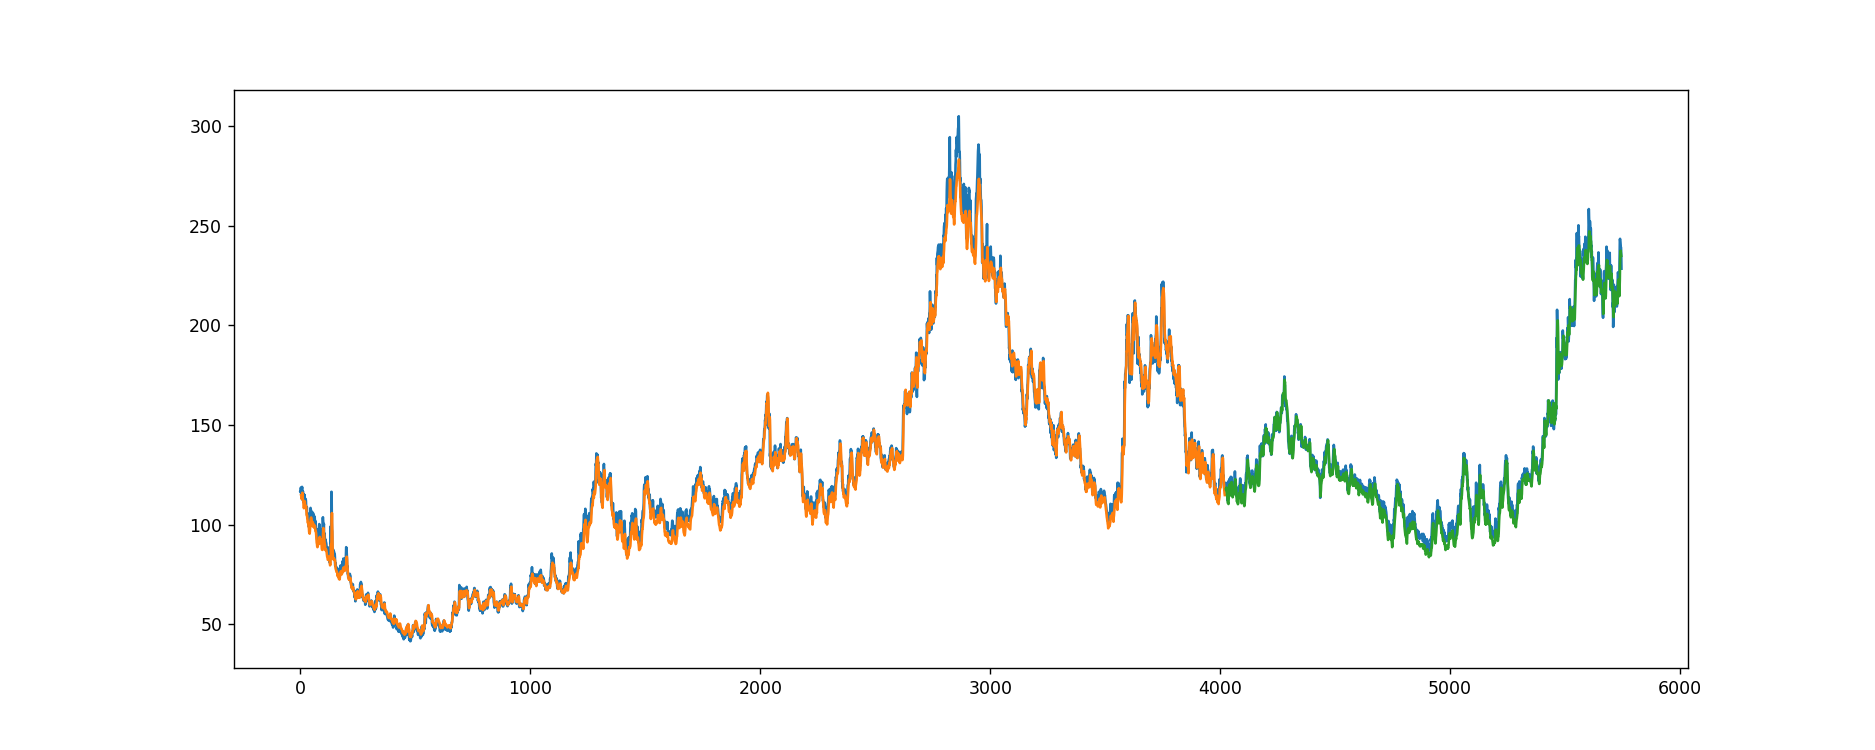

In [183]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


<IPython.core.display.Javascript object>


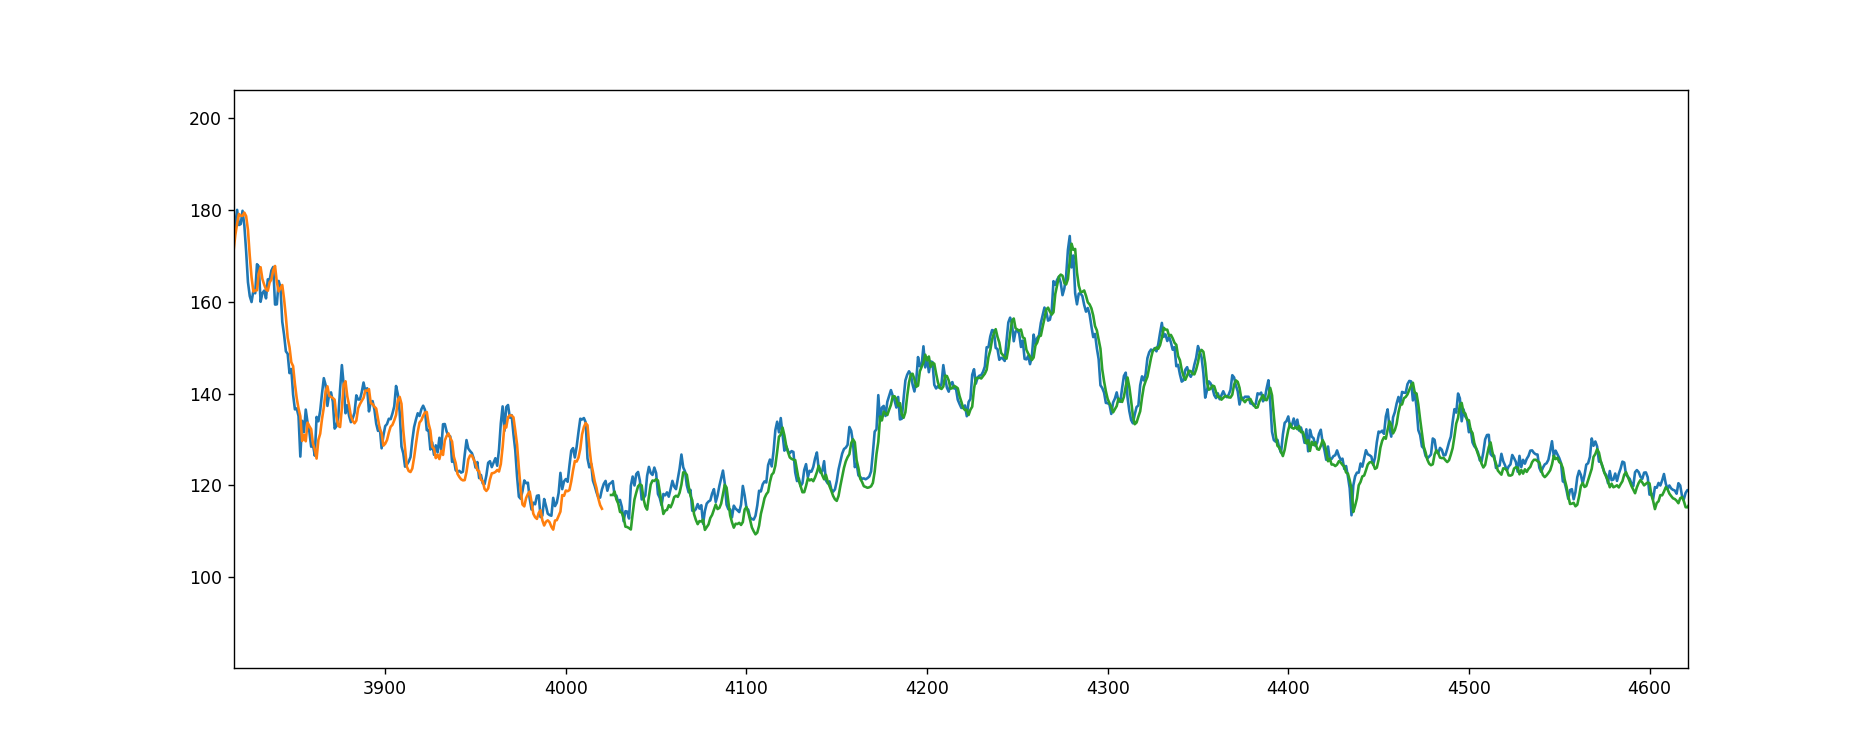

In [184]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()